<a href="https://colab.research.google.com/github/Xenohhhh/Summer-Analytics-25-Week-5/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sample location IDs: ['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01', 'BHMMBMMBX01', 'BHMNCPHST01']


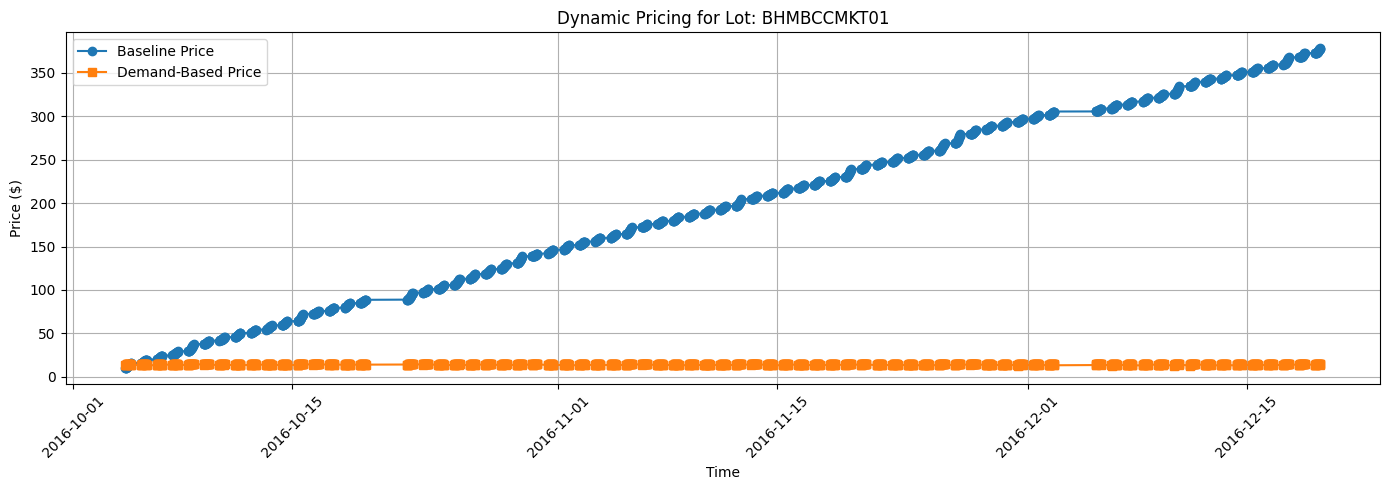

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# STEP 1: Load and clean
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset.csv')
df.columns = df.columns.str.strip().str.lower()

# Combine date and time into timestamp
df['timestamp'] = pd.to_datetime(df['lastupdateddate'] + ' ' + df['lastupdatedtime'], format="%d-%m-%Y %H:%M:%S")

# Rename for clarity
df = df.rename(columns={
    'systemcodenumber': 'location_id',
    'vehicletype': 'vehicle_type',
    'queuelength': 'queue_length',
    'trafficconditionnearby': 'traffic',
    'isspecialday': 'is_special_day'
})

# Clean vehicle type
df['vehicle_type'] = df['vehicle_type'].str.lower().str.strip()

# Convert traffic to numeric (low=1, medium=2, high=3)
traffic_map = {'low': 1, 'medium': 2, 'high': 3}
df['traffic'] = df['traffic'].map(traffic_map).fillna(1)

# Convert all relevant to numeric
cols = ['occupancy', 'capacity', 'queue_length', 'traffic', 'is_special_day']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with invalid data
df = df.dropna(subset=cols)
df = df[df['capacity'] > 0]

# Occupancy rate
df['occupancy_rate'] = df['occupancy'] / df['capacity']

# Vehicle weights
vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.5}
df['vehicle_weight'] = df['vehicle_type'].map(vehicle_weights).fillna(1.0)

# STEP 2: Baseline Pricing (Model 1)
df = df.sort_values(by=['location_id', 'timestamp'])
baseline_prices = []
for lot in df['location_id'].unique():
    prev_price = 10
    for occ_rate in df[df['location_id'] == lot]['occupancy_rate']:
        new_price = prev_price + 1.0 * occ_rate
        baseline_prices.append(round(new_price, 2))
        prev_price = new_price
df['baseline_price'] = baseline_prices

# STEP 3: Demand-based Pricing (Model 2)
df['raw_demand'] = (
    1.0 * df['occupancy_rate'] +     # increase weight
    0.6 * df['queue_length'] -       # increase queue impact
    0.5 * df['traffic'] +            # make traffic reduce more
    0.4 * df['is_special_day'] +
    0.5 * df['vehicle_weight']
)


df['norm_demand'] = 1 / (1 + np.exp(-df['raw_demand']))
df['demand_price'] = 10 * (1 + 0.5 * df['norm_demand'])
df['demand_price'] = df['demand_price'].clip(lower=5, upper=20).round(2)

# STEP 4: Plot prices for a location
def plot_prices(df, location_id):
    df_lot = df[df['location_id'] == location_id].copy()
    df_lot = df_lot.sort_values('timestamp')
    plt.figure(figsize=(14, 5))
    plt.plot(df_lot['timestamp'], df_lot['baseline_price'], label='Baseline Price', marker='o')
    plt.plot(df_lot['timestamp'], df_lot['demand_price'], label='Demand-Based Price', marker='s')
    plt.title(f'Dynamic Pricing for Lot: {location_id}')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔍 Step 5: Check available location IDs and plot one
print("Sample location IDs:", df['location_id'].unique().tolist()[:5])

# Example: plot for 'BHMBCCMKT01'
plot_prices(df, location_id='BHMBCCMKT01')
